In [1]:
# CNN does what it’s good at → images

# MLP does what it’s good at → tabular data

# Model learns complementary information

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import pandas as pd
import tensorflow as tf
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score,accuracy_score, average_precision_score
import seaborn as sns
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
import cv2
import os
from sklearn.feature_selection import SelectKBest, f_classif
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping



In [24]:
df = pd.read_csv(r'Data\Dataset.csv')
df

,id,log-sigma-1-0-mm-3D_glrlm_GrayLevelNonUniformity,log-sigma-1-0-mm-3D_ngtdm_Coarseness,minor_axis_length,area,log-sigma-1-0-mm-3D_gldm_DependenceNonUniformity,log-sigma-2-0-mm-3D_ngtdm_Coarseness,log-sigma-2-0-mm-3D_gldm_DependenceNonUniformity,log-sigma-2-0-mm-3D_glrlm_GrayLevelNonUniformity,wavelet-H_ngtdm_Coarseness,...,wavelet-H_glcm_JointEntropy,wavelet-H_glrlm_GrayLevelNonUniformityNormalized,log-sigma-2-0-mm-3D_glrlm_GrayLevelNonUniformityNormalized,log-sigma-1-0-mm-3D_glrlm_HighGrayLevelRunEmphasis,log-sigma-2-0-mm-3D_glcm_MCC,LBP_hist_bin_7,log-sigma-1-0-mm-3D_gldm_HighGrayLevelEmphasis,label,unexplained_infertility,previous_miscarriages
0,1,4809.535706,0.000247,198.625804,34583,12731.61441,0.000467,13018.03444,2687.906126,0.000138,...,3.863600,0.275603,0.205812,110.158185,0.839618,0.054680,111.058150,0,0,0
1,2,4460.623751,0.000284,193.191790,32053,11900.13194,0.000526,11521.54435,2826.917297,0.000162,...,4.119202,0.252179,0.187636,72.062320,0.853366,0.063489,72.682151,0,0,0
2,3,4925.207181,0.000240,199.327172,34346,13081.91446,0.000431,13580.04041,2784.541071,0.000135,...,3.434695,0.314459,0.231505,56.084546,0.845357,0.060094,56.346329,0,0,0
3,4,4664.352654,0.000257,195.713530,34131,12645.47833,0.000490,12945.91348,2610.770111,0.000141,...,3.599379,0.297244,0.199265,72.034173,0.868814,0.058949,72.831414,0,0,0
4,5,4420.923359,0.000271,196.147021,32842,12027.18696,0.000530,11766.90250,2474.527556,0.000152,...,3.922065,0.272541,0.179913,72.190030,0.855325,0.061050,72.673284,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,124,4568.094233,0.000288,219.654077,39686,14367.67661,0.000472,14273.76697,3055.538006,0.000139,...,3.333863,0.321830,0.175555,90.434190,0.869936,0.069445,90.857481,1,0,1
124,125,4664.626825,0.000275,218.066669,39662,14590.95351,0.000430,14823.92587,3175.472188,0.000136,...,3.076035,0.349690,0.193674,72.112061,0.883472,0.069538,72.611845,1,1,0
125,126,5203.038054,0.000240,229.486021,41192,14904.76695,0.000434,14441.28705,3412.583833,0.000128,...,4.018386,0.262754,0.175031,72.478047,0.846720,0.072174,72.935619,1,0,1
126,127,5362.058473,0.000235,227.372063,40050,14744.51181,0.000405,14445.17743,3592.559575,0.000131,...,4.098497,0.255446,0.195726,110.253146,0.847308,0.059026,110.723695,1,1,0


In [25]:
tabular_features = df.drop(['id', 'label', 'unexplained_infertility'], axis=1)
labels = df['label']


In [26]:
corr_matrix = tabular_features.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
tabular_features_reduced = tabular_features.drop(to_drop, axis=1)
print(f"Dropped {len(to_drop)} redundant features.")

Dropped 234 redundant features.


In [27]:
selector = SelectKBest(score_func=f_classif, k=50)
x_tabular_selected = selector.fit_transform(tabular_features_reduced, labels)
selected_names = tabular_features_reduced.columns[selector.get_support()]
print("Top 10 features:", selected_names[:10].tolist())

Top 10 features: ['log-sigma-1-0-mm-3D_glrlm_GrayLevelNonUniformity', 'log-sigma-1-0-mm-3D_ngtdm_Coarseness', 'minor_axis_length', 'log-sigma-2-0-mm-3D_ngtdm_Coarseness', 'log-sigma-2-0-mm-3D_glrlm_GrayLevelNonUniformity', 'perimeter', 'wavelet-H_gldm_DependenceNonUniformity', 'log-sigma-3-0-mm-3D_ngtdm_Coarseness', 'log-sigma-1-0-mm-3D_gldm_GrayLevelNonUniformity', 'wavelet-H_glrlm_GrayLevelNonUniformity']


In [28]:
Scaler = StandardScaler()
x_tabular_final = Scaler.fit_transform(x_tabular_selected)
y = labels.values

In [29]:
height, width = 256, 256 
batch_size=16

In [30]:
image_folder = r"C:\Users\wesal\OneDrive\Desktop\Junior-fall\Machine Learning\Uterine-Abnormality\Ultrasound-Based-Classification-of-Uterine-Abnormalities\data\images"


image_list = []

for img_id in df['id']:
    img_name = f"{int(img_id):04d}" 
    img_name += '.jpg'
    
    img_path = os.path.join(image_folder, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        print(f"Warning: image not found -> {img_path}")
        continue
    
    img = img / 255.0
    
    img = img[..., np.newaxis]
    
    image_list.append(img)

X_img = np.array(image_list, dtype=np.float32)
print("Images loaded:", X_img.shape)

Images loaded: (128, 256, 256, 1)


In [31]:
X_img_temp, X_img_test, X_tab_temp, X_tab_test, y_temp, y_test = train_test_split(
    X_img, x_tabular_final, y,
    test_size=0.15,
    random_state=42,
    stratify=y
)

X_img_train, X_img_val, X_tab_train, X_tab_val, y_train, y_val = train_test_split(
    X_img_temp, X_tab_temp, y_temp,
    test_size=0.176,   # 0.176 × 85% ≈ 15% of total
    random_state=42,
    stratify=y_temp
)


In [32]:
image_input = Input(shape=(256, 256, 1))
x = RandomFlip("horizontal")(image_input)
x = RandomRotation(0.1)(x)   
x = RandomZoom(0.1)(x)  

x = Conv2D(32, (3,3), kernel_regularizer=l2(1e-4), padding='same')(x)
x = BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = MaxPooling2D((3,3))(x)

x = Conv2D(64, (3,3), kernel_regularizer=l2(1e-4),  padding='same')(x)
x = BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = MaxPooling2D((3,3))(x)
# x = Flatten()(x)
x = Conv2D(128, (3,3), kernel_regularizer=l2(1e-4) , padding='same')(x)
x = BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = GlobalAveragePooling2D()(x)

x = Dense(64,     kernel_regularizer=l2(1e-4), activation='relu')(x)
x = Dropout(0.3)(x)
#GAP keeps the essence of each feature map, but dramatically reduces model size.



# MLP for tabular
tab_input = Input(shape=(x_tabular_final.shape[1],))
y = Dense(128, kernel_regularizer=l2(1e-4))(tab_input)
y = BatchNormalization()(y)
y = tf.keras.layers.ReLU()(y)
y = Dropout(0.3)(y)
y = Dense(64, activation='relu')(y)

#fusion
combined = concatenate([x, y])
z = Dense(64, activation='relu')(combined)
z = Dropout(0.3)(z)
output = Dense(1, activation='sigmoid')(z)

model = Model(inputs=[image_input, tab_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=5e-5), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip         │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (RandomFlip)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation     │ (None, 256, 256,  │          0 │ random_flip[0][0] │
│ (RandomRotation)    │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_zoom         │ (None, 256, 256,  │          0 │ random_rotation[… │
│ (RandomZoom)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        320 │ random_zoom[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 85, 85,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 85, 85,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 85, 85,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 85, 85,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 28, 28,    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │      6,528 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                 

 Total params: 125,441 (490.00 KB)

 Trainable params: 124,737 (487.25 KB)

 Non-trainable params: 704 (2.75 KB)

In [33]:
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss', 
    save_best_only=True,  
    verbose=1
)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,       
    restore_best_weights=True,
    verbose=1
)


In [34]:
history = model.fit(
    [X_img_train, X_tab_train],
    y_train,
    validation_data=([X_img_val, X_tab_val], y_val),
    epochs=500,
    batch_size=4,
    callbacks=[checkpoint, early_stop]
    
)


Epoch 1/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.5232 - loss: 0.7125
Epoch 1: val_loss improved from None to 0.68647, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 323ms/step - accuracy: 0.5000 - loss: 0.7329 - val_accuracy: 0.6000 - val_loss: 0.6865
Epoch 2/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.3825 - loss: 0.7904
Epoch 2: val_loss did not improve from 0.68647
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 216ms/step - accuracy: 0.4773 - loss: 0.7471 - val_accuracy: 0.6000 - val_loss: 0.6866
Epoch 3/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.5209 - loss: 0.7190
Epoch 3: val_loss improved from 0.68647 to 0.68609, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 240ms/step - accuracy: 0.5114 - loss: 0.7090 - val_accuracy: 0.6500 - val_loss: 0.6861
Epoch 4/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.6108 - loss: 0.6946
Epoch 4: val_loss improved from 0.68609 to 0.68342, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 221ms/step - accuracy: 0.5682 - loss: 0.7199 - val_accuracy: 0.6000 - val_loss: 0.6834
Epoch 5/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.6386 - loss: 0.6903
Epoch 5: val_loss improved from 0.68342 to 0.68094, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - accuracy: 0.5568 - loss: 0.7213 - val_accuracy: 0.6000 - val_loss: 0.6809
Epoch 6/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.5419 - loss: 0.7140
Epoch 6: val_loss improved from 0.68094 to 0.67869, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - accuracy: 0.5682 - loss: 0.7003 - val_accuracy: 0.6000 - val_loss: 0.6787
Epoch 7/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.5317 - loss: 0.7461
Epoch 7: val_loss improved from 0.67869 to 0.67562, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - accuracy: 0.5341 - loss: 0.7320 - val_accuracy: 0.6000 - val_loss: 0.6756
Epoch 8/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.7149 - loss: 0.6486
Epoch 8: val_loss improved from 0.67562 to 0.67244, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 244ms/step - accuracy: 0.6477 - loss: 0.6691 - val_accuracy: 0.6000 - val_loss: 0.6724
Epoch 9/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.5822 - loss: 0.6921
Epoch 9: val_loss improved from 0.67244 to 0.66735, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 257ms/step - accuracy: 0.6023 - loss: 0.6878 - val_accuracy: 0.6000 - val_loss: 0.6673
Epoch 10/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.5985 - loss: 0.6945
Epoch 10: val_loss improved from 0.66735 to 0.66396, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - accuracy: 0.5455 - loss: 0.7060 - val_accuracy: 0.6000 - val_loss: 0.6640
Epoch 11/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.6247 - loss: 0.6512
Epoch 11: val_loss improved from 0.66396 to 0.65862, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - accuracy: 0.5682 - loss: 0.6822 - val_accuracy: 0.6000 - val_loss: 0.6586
Epoch 12/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.6319 - loss: 0.6549
Epoch 12: val_loss improved from 0.65862 to 0.65505, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - accuracy: 0.6136 - loss: 0.6565 - val_accuracy: 0.6500 - val_loss: 0.6551
Epoch 13/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.6875 - loss: 0.6797
Epoch 13: val_loss improved from 0.65505 to 0.65197, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - accuracy: 0.6932 - loss: 0.6610 - val_accuracy: 0.6500 - val_loss: 0.6520
Epoch 14/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.5260 - loss: 0.7142
Epoch 14: val_loss improved from 0.65197 to 0.64894, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - accuracy: 0.5455 - loss: 0.6992 - val_accuracy: 0.6500 - val_loss: 0.6489
Epoch 15/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.6335 - loss: 0.6735
Epoch 15: val_loss improved from 0.64894 to 0.64717, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 237ms/step - accuracy: 0.5795 - loss: 0.6739 - val_accuracy: 0.6500 - val_loss: 0.6472
Epoch 16/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.7010 - loss: 0.6720
Epoch 16: val_loss improved from 0.64717 to 0.64145, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 280ms/step - accuracy: 0.6932 - loss: 0.6592 - val_accuracy: 0.6500 - val_loss: 0.6415
Epoch 17/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.6032 - loss: 0.6760
Epoch 17: val_loss improved from 0.64145 to 0.63833, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - accuracy: 0.6477 - loss: 0.6603 - val_accuracy: 0.6500 - val_loss: 0.6383
Epoch 18/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.5127 - loss: 0.7560
Epoch 18: val_loss improved from 0.63833 to 0.63656, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 291ms/step - accuracy: 0.5682 - loss: 0.7068 - val_accuracy: 0.7000 - val_loss: 0.6366
Epoch 19/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.6660 - loss: 0.6467
Epoch 19: val_loss improved from 0.63656 to 0.63298, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 261ms/step - accuracy: 0.5909 - loss: 0.6792 - val_accuracy: 0.7000 - val_loss: 0.6330
Epoch 20/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.5827 - loss: 0.6756
Epoch 20: val_loss improved from 0.63298 to 0.62951, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 261ms/step - accuracy: 0.5909 - loss: 0.6946 - val_accuracy: 0.7000 - val_loss: 0.6295
Epoch 21/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.7117 - loss: 0.6355
Epoch 21: val_loss improved from 0.62951 to 0.62361, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 255ms/step - accuracy: 0.6250 - loss: 0.6725 - val_accuracy: 0.7000 - val_loss: 0.6236
Epoch 22/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.6207 - loss: 0.6711
Epoch 22: val_loss improved from 0.62361 to 0.62002, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 272ms/step - accuracy: 0.6477 - loss: 0.6582 - val_accuracy: 0.6500 - val_loss: 0.6200
Epoch 23/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.6059 - loss: 0.6383
Epoch 23: val_loss improved from 0.62002 to 0.61533, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step - accuracy: 0.6023 - loss: 0.6706 - val_accuracy: 0.6500 - val_loss: 0.6153
Epoch 24/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.5277 - loss: 0.7011
Epoch 24: val_loss improved from 0.61533 to 0.61147, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 289ms/step - accuracy: 0.5455 - loss: 0.6918 - val_accuracy: 0.6500 - val_loss: 0.6115
Epoch 25/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.6473 - loss: 0.6640
Epoch 25: val_loss improved from 0.61147 to 0.60509, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 253ms/step - accuracy: 0.6477 - loss: 0.6590 - val_accuracy: 0.7500 - val_loss: 0.6051
Epoch 26/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.7626 - loss: 0.6046
Epoch 26: val_loss improved from 0.60509 to 0.60146, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 253ms/step - accuracy: 0.7386 - loss: 0.6170 - val_accuracy: 0.7000 - val_loss: 0.6015
Epoch 27/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.4870 - loss: 0.7326
Epoch 27: val_loss did not improve from 0.60146
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 262ms/step - accuracy: 0.5114 - loss: 0.7122 - val_accuracy: 0.7000 - val_loss: 0.6015
Epoch 28/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.7400 - loss: 0.5984
Epoch 28: val_loss did not improve from 0.60146
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 246ms/step - accuracy: 0.7386 - loss: 0.6065 - val_accuracy: 0.5500 - val_loss: 0.6059
Epoch 29/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.7940 - loss: 0.6217
Epoch 29: val_loss improved from 0.60146 to 0.59931, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 256ms/step - accuracy: 0.7273 - loss: 0.6279 - val_accuracy: 0.6000 - val_loss: 0.5993
Epoch 30/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.5865 - loss: 0.6357
Epoch 30: val_loss improved from 0.59931 to 0.59365, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 248ms/step - accuracy: 0.6364 - loss: 0.6340 - val_accuracy: 0.7000 - val_loss: 0.5936
Epoch 31/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.6637 - loss: 0.6375
Epoch 31: val_loss did not improve from 0.59365
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 242ms/step - accuracy: 0.6591 - loss: 0.6396 - val_accuracy: 0.6500 - val_loss: 0.5947
Epoch 32/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.8081 - loss: 0.5943
Epoch 32: val_loss improved from 0.59365 to 0.59073, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 410ms/step - accuracy: 0.7386 - loss: 0.6310 - val_accuracy: 0.7000 - val_loss: 0.5907
Epoch 33/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.6454 - loss: 0.6712
Epoch 33: val_loss improved from 0.59073 to 0.58962, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 278ms/step - accuracy: 0.6818 - loss: 0.6429 - val_accuracy: 0.6500 - val_loss: 0.5896
Epoch 34/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.5629 - loss: 0.6652
Epoch 34: val_loss did not improve from 0.58962
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 274ms/step - accuracy: 0.5227 - loss: 0.7050 - val_accuracy: 0.6000 - val_loss: 0.5941
Epoch 35/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.7773 - loss: 0.6013
Epoch 35: val_loss improved from 0.58962 to 0.58960, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 480ms/step - accuracy: 0.7273 - loss: 0.6248 - val_accuracy: 0.7000 - val_loss: 0.5896
Epoch 36/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.6765 - loss: 0.6199
Epoch 36: val_loss did not improve from 0.58960
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 200ms/step - accuracy: 0.6818 - loss: 0.6347 - val_accuracy: 0.6000 - val_loss: 0.5949
Epoch 37/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.6221 - loss: 0.6724
Epoch 37: val_loss improved from 0.58960 to 0.58714, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 264ms/step - accuracy: 0.6591 - loss: 0.6519 - val_accuracy: 0.6500 - val_loss: 0.5871
Epoch 38/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.7850 - loss: 0.5428
Epoch 38: val_loss did not improve from 0.58714
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 266ms/step - accuracy: 0.7727 - loss: 0.5672 - val_accuracy: 0.6000 - val_loss: 0.5875
Epoch 39/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.7204 - loss: 0.6033
Epoch 39: val_loss improved from 0.58714 to 0.58663, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - accuracy: 0.7159 - loss: 0.6078 - val_accuracy: 0.6000 - val_loss: 0.5866
Epoch 40/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.6471 - loss: 0.6595
Epoch 40: val_loss improved from 0.58663 to 0.57679, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 267ms/step - accuracy: 0.6591 - loss: 0.6411 - val_accuracy: 0.6500 - val_loss: 0.5768
Epoch 41/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.7776 - loss: 0.6112
Epoch 41: val_loss did not improve from 0.57679
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 280ms/step - accuracy: 0.6818 - loss: 0.6299 - val_accuracy: 0.6000 - val_loss: 0.5922
Epoch 42/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.7336 - loss: 0.5903
Epoch 42: val_loss did not improve from 0.57679
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 248ms/step - accuracy: 0.6932 - loss: 0.6256 - val_accuracy: 0.6500 - val_loss: 0.6043
Epoch 43/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.6993 - loss: 0.6274
Epoch 43: val_loss did not improve from 0.57679
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step - accuracy: 0.7386 - loss: 0.6051 - val_accuracy: 0.6500 - val_loss: 0.5923
Epoch 44/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7592 - loss: 0.5805
Epoch 44: val_loss did not improve f

22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 255ms/step - accuracy: 0.7045 - loss: 0.5859 - val_accuracy: 0.6500 - val_loss: 0.5739
Epoch 50/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.6184 - loss: 0.6618
Epoch 50: val_loss improved from 0.57390 to 0.56418, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 243ms/step - accuracy: 0.6705 - loss: 0.6201 - val_accuracy: 0.6500 - val_loss: 0.5642
Epoch 51/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.7212 - loss: 0.5750
Epoch 51: val_loss did not improve from 0.56418
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 244ms/step - accuracy: 0.7045 - loss: 0.6036 - val_accuracy: 0.6500 - val_loss: 0.5716
Epoch 52/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.6599 - loss: 0.6036
Epoch 52: val_loss did not improve from 0.56418
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 247ms/step - accuracy: 0.6932 - loss: 0.5759 - val_accuracy: 0.6000 - val_loss: 0.5799
Epoch 53/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.6100 - loss: 0.6251
Epoch 53: val_loss did not improve from 0.56418
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step - accuracy: 0.6477 - loss: 0.6224 - val_accuracy: 0.6000 - val_loss: 0.5775
Epoch 54/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.7978 - loss: 0.5441
Epoch 54: val_loss did not improve f

22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 256ms/step - accuracy: 0.6250 - loss: 0.6186 - val_accuracy: 0.6500 - val_loss: 0.5619
Epoch 59/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.7330 - loss: 0.5758
Epoch 59: val_loss did not improve from 0.56188
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 247ms/step - accuracy: 0.7500 - loss: 0.5790 - val_accuracy: 0.6500 - val_loss: 0.5659
Epoch 60/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.6604 - loss: 0.6039
Epoch 60: val_loss improved from 0.56188 to 0.55319, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 268ms/step - accuracy: 0.6932 - loss: 0.6011 - val_accuracy: 0.6500 - val_loss: 0.5532
Epoch 61/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.6780 - loss: 0.6062
Epoch 61: val_loss did not improve from 0.55319
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 253ms/step - accuracy: 0.6932 - loss: 0.5740 - val_accuracy: 0.6500 - val_loss: 0.5577
Epoch 62/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.6921 - loss: 0.5751
Epoch 62: val_loss did not improve from 0.55319
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 217ms/step - accuracy: 0.7159 - loss: 0.5939 - val_accuracy: 0.6500 - val_loss: 0.5555
Epoch 63/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.6064 - loss: 0.6147
Epoch 63: val_loss did not improve from 0.55319
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step - accuracy: 0.6591 - loss: 0.5954 - val_accuracy: 0.6500 - val_loss: 0.5545
Epoch 64/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.7459 - loss: 0.5251
Epoch 64: val_loss improved from 0.

22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 263ms/step - accuracy: 0.7500 - loss: 0.5428 - val_accuracy: 0.7000 - val_loss: 0.5504
Epoch 65/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.7636 - loss: 0.5528
Epoch 65: val_loss did not improve from 0.55043
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 256ms/step - accuracy: 0.7159 - loss: 0.6021 - val_accuracy: 0.6500 - val_loss: 0.5596
Epoch 66/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.7005 - loss: 0.5980
Epoch 66: val_loss did not improve from 0.55043
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 236ms/step - accuracy: 0.7500 - loss: 0.5945 - val_accuracy: 0.6500 - val_loss: 0.5667
Epoch 67/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.7227 - loss: 0.5981
Epoch 67: val_loss did not improve from 0.55043
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 249ms/step - accuracy: 0.7386 - loss: 0.5827 - val_accuracy: 0.6500 - val_loss: 0.5735
Epoch 68/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.7452 - loss: 0.5870
Epoch 68: val_loss did not improve 


==================== VALIDATION REPORT ====================
Accuracy:  0.7000
ROC AUC:   0.8283
PR AUC:    0.7843

Classification Report:
              precision    recall  f1-score   support

      Normal       0.69      0.82      0.75        11
    Abnormal       0.71      0.56      0.62         9

    accuracy                           0.70        20
   macro avg       0.70      0.69      0.69        20
weighted avg       0.70      0.70      0.69        20


==================== TEST REPORT ====================
Accuracy:  0.7000
ROC AUC:   0.8081
PR AUC:    0.8175

Classification Report:
              precision    recall  f1-score   support

      Normal       0.73      0.73      0.73        11
    Abnormal       0.67      0.67      0.67         9

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20



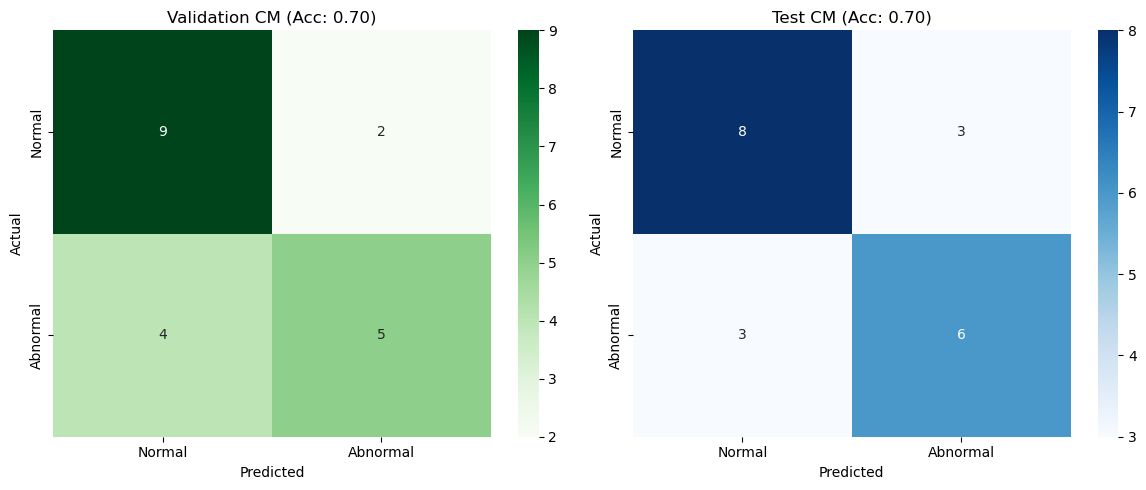

In [35]:
def evaluate_set(images, tabular, labels, set_name):
    probs = model.predict([images, tabular], verbose=0).ravel()
    preds = (probs > 0.5).astype(int)
    
    acc = accuracy_score(labels, preds)
    auc = roc_auc_score(labels, probs)
    ap = average_precision_score(labels, probs)
    
    print(f"\n{'='*20} {set_name.upper()} REPORT {'='*20}")
    print(f"Accuracy:  {acc:.4f}")
    print(f"ROC AUC:   {auc:.4f}")
    print(f"PR AUC:    {ap:.4f}")
    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=['Normal', 'Abnormal']))
    
    return confusion_matrix(labels, preds), acc

cm_val, acc_val = evaluate_set(X_img_val, X_tab_val, y_val, "Validation")
cm_test, acc_test = evaluate_set(X_img_test, X_tab_test, y_test, "Test")

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens', ax=ax[0],
            xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
ax[0].set_title(f'Validation CM (Acc: {acc_val:.2f})')
ax[0].set_ylabel('Actual')
ax[0].set_xlabel('Predicted')

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=ax[1],
            xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
ax[1].set_title(f'Test CM (Acc: {acc_test:.2f})')
ax[1].set_ylabel('Actual')
ax[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()


In [36]:
from tensorflow.keras.models import load_model

best_model = load_model('best_model.h5')


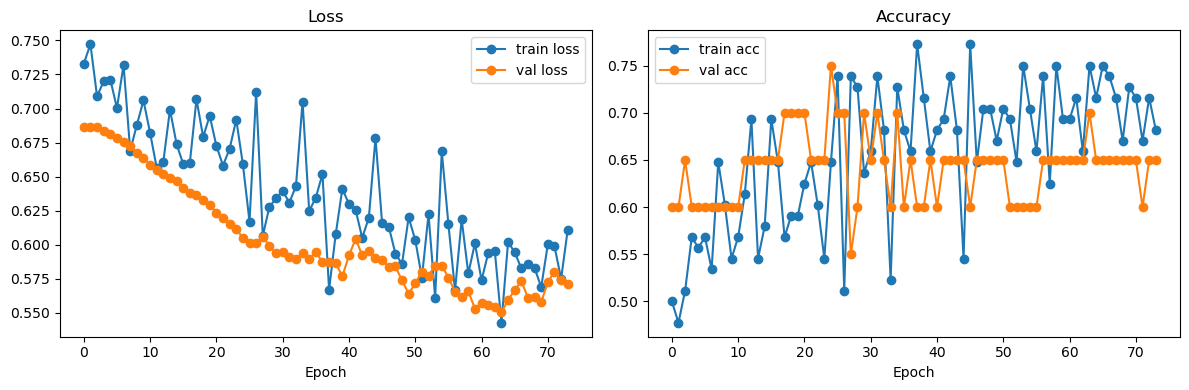

In [37]:
history_dict = history.history
loss = history_dict.get('loss')
val_loss = history_dict.get('val_loss')
acc = history_dict.get('accuracy', history_dict.get('acc'))
val_acc = history_dict.get('val_accuracy', history_dict.get('val_acc'))

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(loss, 'o-', label='train loss')
plt.plot(val_loss, 'o-', label='val loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
if acc is not None and val_acc is not None:
    plt.plot(acc, 'o-', label='train acc')
    plt.plot(val_acc, 'o-', label='val acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
else:
    plt.text(0.5, 0.5, 'No accuracy data in history', ha='center', va='center')

plt.tight_layout()
plt.show()